In [1]:
from pathlib import Path
import fileinput
import pandas as pd

Get a set of all the truth probes that map to GC00002360 in "no_denovo"

In [2]:
def get_reports(covg: str, with_denovo: bool) -> list:
    denovo = "with" if with_denovo else "no"
    report_dir = Path("reports/")
    return list(report_dir.rglob(f"*/{covg}/pandora_nanopore_filter_{denovo}_denovo/*.tsv"))
    

In [3]:
gene = "GC00002360"
covg = "100x"
reports = get_reports(covg, with_denovo=False)

In [4]:
no_denovo_probes_map_to_gene = set()
with fileinput.input(reports) as fh:
    for line in fh:
        if gene in line:
            truth_probe_header = line.split("\t")[1]
            no_denovo_probes_map_to_gene.add(truth_probe_header)
            

Lets take a look at what variant probes these truth probes do/dont map to for "with_denovo"


In [5]:
with_denovo_reports = get_reports(covg, with_denovo=True)

In [6]:
df = pd.concat([pd.read_csv(p, sep="\t") for p in with_denovo_reports])

In [7]:
probes_of_interest = df.loc[df['query_probe_header'].isin(no_denovo_probes_map_to_gene)]
len(probes_of_interest)

890

In [8]:
from collections import Counter
Counter(probes_of_interest["classification"])



Counter({'unmapped': 890})

So it appears that **every** truth probe that maps to GC00002360 in "no_denovo" is unmapped in "with_denovo"!  
Lets look at how many truth probes map to GC00002360 in "with_denovo"

In [9]:
with_denovo_probes_map_to_gene = set()
with fileinput.input(with_denovo_reports) as fh:
    for line in fh:
        if gene in line:
            truth_probe_header = line.split("\t")[1]
            with_denovo_probes_map_to_gene.add(truth_probe_header)
len(with_denovo_probes_map_to_gene)

0

In a separate analysis, I have found that there is an edit distance of 36 between the VCF references for this gene in no_denovo and with_denovo.

The next thing to try is to look at how different the VCF records relating to this gene are for both methods.




In [10]:
import allel



In [11]:
no_denovo_vcf = "analysis/100x/filter/compare_no_denovo/pandora_multisample_genotyped.vcf"
with_denovo_vcf = "analysis/100x/filter/compare_with_denovo/pandora_multisample_genotyped.vcf"
vcf_fields = ["calldata/GT", "samples", "variants/CHROM", "variants/POS", ]

In [18]:
no_denovo_callset = allel.read_vcf(no_denovo_vcf, fields=vcf_fields, region=gene)
sorted(no_denovo_callset.keys())

/home/michael/.local/share/virtualenvs/pandora1_paper-0BSWecqc/lib/python3.6/site-packages/allel/io/vcf_read.py:1257: UserWarning: 'GT' FORMAT header not found
  warnings.warn('%r FORMAT header not found' % name)


['calldata/GT', 'samples', 'variants/CHROM', 'variants/POS']

In [19]:
with_denovo_callset = allel.read_vcf(with_denovo_vcf, fields=vcf_fields, region=gene)

In [20]:
no_denovo_gt = allel.GenotypeArray(no_denovo_callset['calldata/GT'])
with_denovo_gt = allel.GenotypeArray(with_denovo_callset['calldata/GT'])

In [33]:
no_denovo_haploid_calls = []
for a in no_denovo_gt:
    no_denovo_haploid_calls.extend([x[0] for x in a])

print(Counter(no_denovo_haploid_calls))

Counter({0: 762, 1: 94, -1: 87, 2: 46, 3: 9, 4: 4, 12: 1, 7: 1})


In [34]:
with_denovo_haploid_calls = []
for a in with_denovo_gt:
    with_denovo_haploid_calls.extend([x[0] for x in a])

print(Counter(with_denovo_haploid_calls))

Counter({-1: 1028, 1: 3, 0: 1})


So it looks like the problem here is that "with_denovo" has nearly all null calls for this gene, whereas "no_denovo" has lots of non-null calls


In [32]:
import seaborn as sns
import matplotlib.pyplot as plt


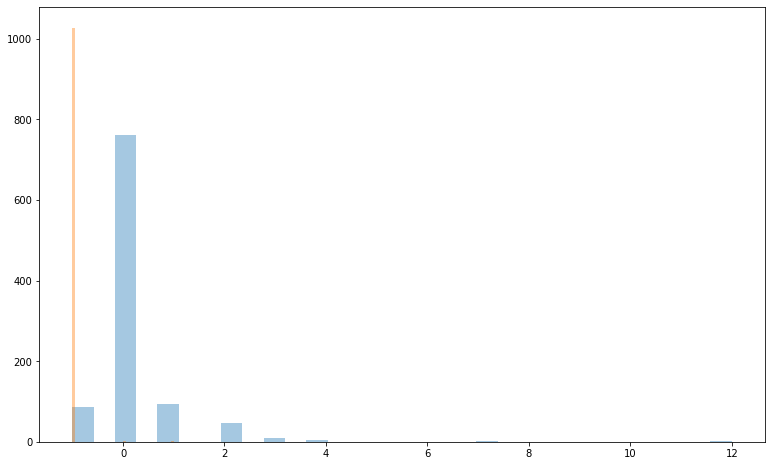

In [41]:
fig, ax = plt.subplots(figsize=(13,8))
sns.distplot(no_denovo_haploid_calls, ax=ax, label="no_denovo", kde=False)
sns.distplot(with_denovo_haploid_calls, ax=ax, label="with_denovo", kde=False)